# Learning Physics

A bunch of experiments with regards to solving physics problems with neural networks.

In [1]:
import torch
import matplotlib.pyplot as plt

## IVP

A lot of problems require obtaining the trajectory from a ODE and an initial state. The ode is given as 
$$
    \dot{x} = f(t, x)
$$

The solution can be obtained by integrating $f(t, x)$ over time. I am going to use a Runge-Kutta integrator:

$$
    y_{n+1} = y_n + h \sum^{s}_{i=1} b_i k_i
$$

where 

$$
\begin{align}
 k_1 & = f(t_n, y_n), \\
 k_2 & = f(t_n+c_2h, y_n+(a_{21}k_1)h), \\
 k_3 & = f(t_n+c_3h, y_n+(a_{31}k_1+a_{32}k_2)h), \\
 k_4 & = f(t_n+c_4h, y_n+(a_{41}k_1+a_{42}k_2+a_{43}k_3)h), \\
     & \ \ \vdots \\
 k_s & = f(t_n+c_sh, y_n+(a_{s1}k_1+a_{s2}k_2+\cdots+a_{s,s-1}k_{s-1})h).
\end{align}  
$$

$h$ is the stepsize $t_{n+1} = t_{n} + h$. $c_n$, $b_n$ and $a_{ij}$ can be taken from the Butcher tableau

$$
\begin{array}{c|ccccc}
0 & \\
c_2 & a_{21} \\
c_3 & a_{31} & a_{32} \\
\vdots & \vdots & & \ddots \\
c_s & a_{s1} & a_{s2} & \cdots & a_{s,s-1} \\
\hline
& b_1 & b_2 & \cdots & b_{s-1} & b_s
\end{array}
$$.

I use a 4th order integator (RK4) with the tableau (trapezoid rule is 2nd order):

$$
\begin{array}{c|ccc}
0 & & & \\
\frac{1}{2} & \frac{1}{2} & & \\
\frac{1}{2} & 0 & \frac{1}{2} & \\
1 & 0 & 0 & 1 \\
\hline
& \frac{1}{6} & \frac{1}{3} & \frac{1}{3} & \frac{1}{6}
\end{array}
$$

In [2]:
def rk4(f, y0, t):
    # butcher tableau
    c = torch.as_tensor([0, 1/2, 1/2, 1])
    b = torch.as_tensor([1/6, 1/3, 1/3, 1/6])
    a = torch.as_tensor([
        [0,   0,   0, 0],
        [1/2, 0,   0, 0],
        [0,   1/2, 0, 0],
        [0,   0,   1, 0],
    ])

    # helper functions
    k1 = lambda y, t, h: f(t, y)
    k2 = lambda y, t, h: f(t + c[1] * h, y + a[1, 0] * k1(y, t, h) * h)
    k3 = lambda y, t, h: f(t + c[2] * h, y + (a[2, 0] * k1(y, t, h) + a[2, 1] * k2(y, t, h)) * h)
    k4 = lambda y, t, h: f(t + c[3] * h, y + (a[3, 0] * k1(y, t, h) + a[3, 1] * k2(y, t, h) + a[3, 2] * k3(y, t, h)) * h)

    # perform integration
    y = [y0]
    for t_1, t_2 in zip(t[:-1], t[1:]):
        h = t_2 - t_1
        y.append(y[-1] + h * (b[0] * k1(y[-1], t_1, h) + b[1] * k2(y[-1], t_1, h) + b[2] * k3(y[-1], t_1, h) + b[3] * k4(y[-1], t_1, h)))
    return torch.stack(y)

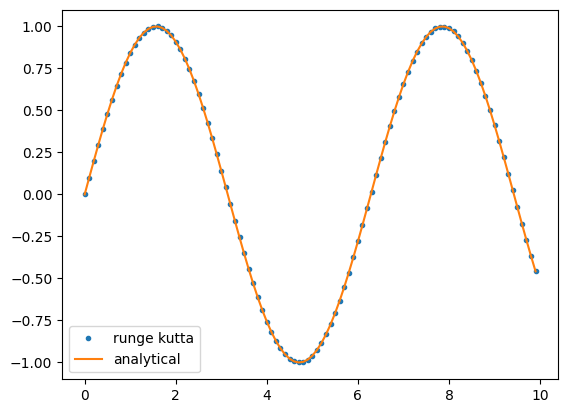

In [3]:
# integrate cos
f = lambda t, x: torch.cos(t)
x0 = torch.as_tensor(0)
t = torch.arange(0, 10, 0.1)

# analytical
y = torch.sin(t)
# runge kutta
y_rk = rk4(f, x0, t)

plt.plot(t, y_rk, ".", label="runge kutta")
plt.plot(t, y, "-", label="analytical")
plt.legend()
plt.show()

### Pendulum

As a quick test I am going to solve the IVP for a simple pendulum. A pendulum of length 1 is described by

$$
\begin{align}
& x = \begin{bmatrix} \phi \\ \omega \end{bmatrix} \\
& \dot{x} = \begin{bmatrix} \dot{\phi} \\ \dot{\omega} \end{bmatrix} = \begin{bmatrix} \omega \\ -g \sin(\phi) \end{bmatrix} = f(x)
\end{align}
$$

where $\phi$ is the angle of the pendulum.


<div align=center>
<img src="https://upload.wikimedia.org/wikipedia/commons/b/b2/Simple_gravity_pendulum.svg" width="500"/>
</div>

In [4]:
def f(t, x):
    # x has two values, first the angle, then the velocity
    phi = x[0]
    omega = x[1]
    g = 9.81

    phi_dot = omega
    omega_dot = -g * torch.sin(phi)
    return torch.stack([phi_dot, omega_dot])   

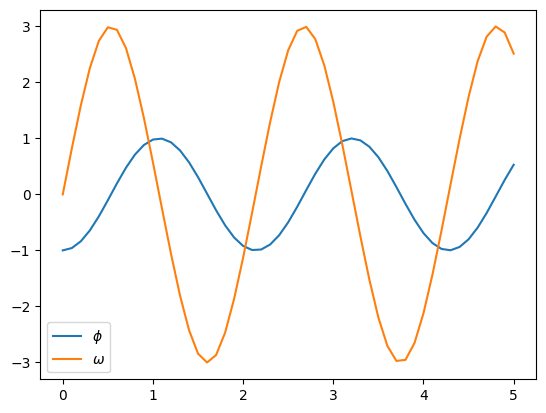

In [5]:
t = torch.arange(0, 5.1, 0.1)
x0 = torch.tensor([-1, 0])
y_rk = rk4(f, x0, t)

plt.plot(t, y_rk[:, 0], label="$\phi$")
plt.plot(t, y_rk[:, 1], label="$\omega$")
plt.legend()
plt.show()

## Lagrangian Neural Networks

Stolen from [og implementation](https://colab.research.google.com/drive/1CSy-xfrnTX28p1difoTA8ulYw0zytJkq#scrollTo=mhUbF1-vXY-b)

Following [Diego Assencio's derivation](https://diego.assencio.com/?index=1500c66ae7ab27bb0106467c68feebc6), the Lagrangian of the double pendulum is 

$$
\begin{align}
L = & \frac{1}{2}(m_1 + m_2) l_1^2 \dot{\theta}_1^2 +
	\frac{1}{2}m_2 l_2^2 \dot{\theta}_2^2 + m_2l_1l_2\dot{\theta}_1\dot{\theta}_2
	\cos(\theta_1 - \theta_2)\nonumber\\[3pt]
     &+ (m_1 + m_2) g l_1 \cos\theta_1 + m_2 g l_2\cos\theta_2
\end{align}
$$

<img src="https://raw.githubusercontent.com/greydanus/greydanus.github.io/master/files/double_pend_schema.png">

In [6]:
def lagrangian(q, q_dot, m1, m2, l1, l2, g):
  t1, t2 = q     # theta 1 and theta 2
  w1, w2 = q_dot # omega 1 and omega 2

  # kinetic energy (T)
  T1 = 0.5 * m1 * (l1 * w1)**2
  T2 = 0.5 * m2 * ((l1 * w1)**2 + (l2 * w2)**2 +
                    2 * l1 * l2 * w1 * w2 * torch.cos(t1 - t2))
  T = T1 + T2
  
  # potential energy (V)
  y1 = -l1 * torch.cos(t1)
  y2 = y1 - l2 * torch.cos(t2)
  V = m1 * g * y1 + m2 * g * y2

  return T - V

We'll want to check our results against an analytical solution. We can use equations 19-22 and 28 from [Diego's derivation](https://diego.assencio.com/?index=1500c66ae7ab27bb0106467c68feebc6):

\begin{align}
& \alpha_1(\theta_1,\theta_2) ~:=~ \displaystyle\frac{l_2}{l_1}\left(\frac{m_2}{m_1 + m_2}\right)\cos(\theta_1 - \theta_2)\\
&\alpha_2(\theta_1,\theta_2) ~:=~ \frac{l_1}{l_2}\cos(\theta_1-\theta_2)\\
&\displaystyle f_1(\theta_1, \theta_2, \dot{\theta}_1, \dot{\theta}_2) ~:=~
-\frac{l_2}{l_1}\left(\frac{m_2}{m_1+m_2}\right) \dot{\theta}_2^2\sin(\theta_1 - \theta_2)
- \frac{g}{l_1} \sin\theta_1 \\
&\displaystyle f_2(\theta_1, \theta_2, \dot{\theta}_1, \dot{\theta}_2) ~:=~
\frac{l_1}{l_2}\dot{\theta}_1^2\sin(\theta_1-\theta_2) - \frac{g}{l_2} \sin\theta_2 \\
&g_1 := \displaystyle\frac{f_1 - \alpha_1 f_2}{1 - \alpha_1\alpha_2}
\quad\quad
g_2 := \displaystyle\frac{-\alpha_2 f_1 + f_2}{1 - \alpha_1\alpha_2}
\end{align}

Having defined these quantities, we can express the analytical dynamics of the system in matrix form:

$$
\displaystyle\frac{d}{dt}
\left( \begin{matrix} \theta_1 \\[1pt] \theta_2 \\[1pt] \omega_1 \\[1pt] \omega_1 \end{matrix} \right)
=
\left( \begin{matrix} \omega_1 \\ \omega_2 \\ g_1(\theta_1,\theta_2,\omega_1,\omega_2)
\\ g_2(\theta_1,\theta_2,\omega_1,\omega_2) \end{matrix} \right)
$$

In [7]:
def f_analytical(state, t=0, m1=1, m2=1, l1=1, l2=1, g=9.8):
  t1, t2, w1, w2 = state
  a1 = (l2 / l1) * (m2 / (m1 + m2)) * torch.cos(t1 - t2)
  a2 = (l1 / l2) * torch.cos(t1 - t2)
  f1 = -(l2 / l1) * (m2 / (m1 + m2)) * (w2**2) * torch.sin(t1 - t2) - \
      (g / l1) * torch.sin(t1)
  f2 = (l1 / l2) * (w1**2) * torch.sin(t1 - t2) - (g / l2) * torch.sin(t2)
  g1 = (f1 - a1 * f2) / (1 - a1 * a2)
  g2 = (f2 - a2 * f1) / (1 - a1 * a2)
  return torch.stack([w1, w2, g1, g2])

In [8]:
def equation_of_motion(lagrangian, state, t=None):
  q, q_t = torch.split(state, 2)
  q_tt = (torch.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  return jnp.concatenate([q_t, q_tt])

def solve_lagrangian(lagrangian, initial_state, **kwargs):
  # We currently run odeint on CPUs only, because its cost is dominated by
  # control flow, which is slow on GPUs.
  @partial(jax.jit, backend='cpu')
  def f(initial_state):
    return odeint(partial(equation_of_motion, lagrangian),
                  initial_state, **kwargs)
  return f(initial_state)

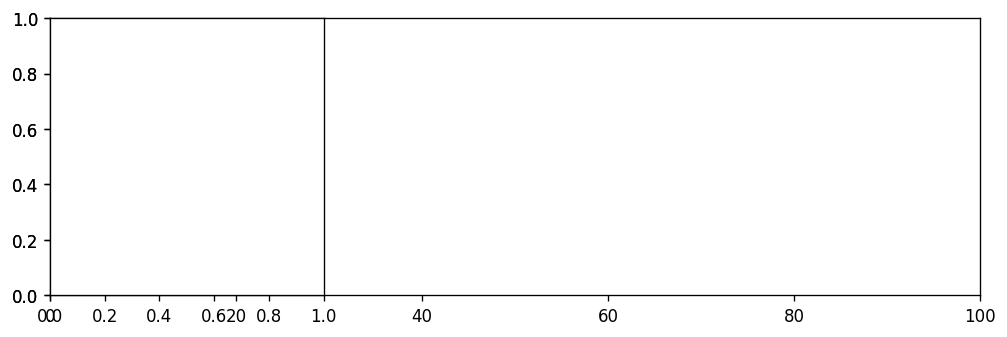

<class 'NameError'>: name 'noise_coeff_1' is not defined

In [9]:
plt.figure(figsize=[10,3], dpi=120) ; plt.xlim(0, 100)
plt.subplot(1,3,1)
plt.title("Analytic vs Perturbed ($\epsilon$={})".format(noise_coeff_1))
plt.xlabel("Time") ; plt.ylabel("State")
plt.plot(t, x_analytical[:, 0], 'g-', label='$q$')
plt.plot(t, x_analytical[:, 1], 'c-', label='$\dot q$')
plt.plot(t, x_perturbed_1[:, 0], 'g--', label='pert. $q$')
plt.plot(t, x_perturbed_1[:, 1], 'c--', label='pert. $\dot q$')
plt.legend(fontsize=6)

plt.subplot(1,3,2)
plt.title("Analytic vs Perturbed ($\epsilon$={})".format(noise_coeff_2))
plt.xlabel("Time") ; plt.ylabel("State")
plt.plot(t, x_analytical[:, 0], 'g-', label='$q$')
plt.plot(t, x_analytical[:, 1], 'c-', label='$\dot q$')
plt.plot(t, x_perturbed_2[:, 0], 'g--', label='pert. $q$')
plt.plot(t, x_perturbed_2[:, 1], 'c--', label='pert. $\dot q$')
plt.legend(fontsize=6)

plt.subplot(1,3,3)
plt.title("Analytic vs Autograd")
plt.xlabel("Time") ; plt.ylabel("State")
plt.plot(t, x_analytical[:, 0], 'g-', label='$q$')
plt.plot(t, x_analytical[:, 1], 'c-', label='$\dot q$')
plt.plot(t, x_autograd[:, 0], 'g--', label='autograd $q$')
plt.plot(t, x_autograd[:, 1], 'c--', label='autograd $\dot q$')
plt.legend(fontsize=6)

plt.tight_layout() ; plt.show()